Credits/Course URL: https://www.udemy.com/course/machinelearning/

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import en_core_web_sm
from nltk.corpus import stopwords
from slugify import Slugify
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luvkush\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

#### Reading the data

In [7]:
data = pd.read_csv(r'E:\Github\Datasets\Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


#### Data Exploration

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


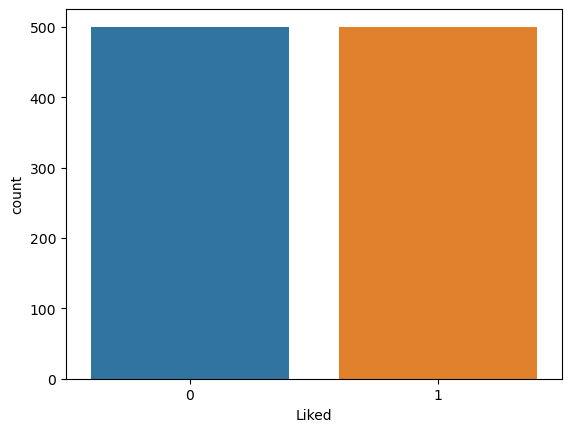

In [10]:
sns.countplot(x = 'Liked', data = data);

#### Data Cleaning

In [25]:
def preprocess_lemma(sentence):
    nlp = spacy.load('en_core_web_sm')
    tokens = [tok.lemma_ for tok in nlp(sentence)]
    tokens = ' '.join(tokens)
    return tokens

In [53]:
def preprocess(sentence):
    
    sentence = sentence.lower()    
    sentence = re.sub(r"https?://[A-Za-z0-9/.-]+", ' ', sentence) # Remove URLs
    custom_slugify = Slugify(to_lower = True, 
                         separator = ' ',
                         safe_chars = '@')
    
    sentence = custom_slugify(sentence) # slugified the sentence
    sentence = re.sub(r"@[A-Za-z0-9]+", '', sentence) # removing twitter username
    sentence = re.sub(r"[0-9]+[A-Za-z]+", '', sentence) # removing strings starting with numbers in the string
    sentence = re.sub(r"[0-9]+", '', sentence) # removing numbers in the string
    sentence = re.sub(r'((\w)\2{2,})', '', sentence) # Repeated words removed
    sentence = re.sub('[^a-zA-z]', ' ', sentence) # remove everything except alphabets
    
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    all_stopwords = set(all_stopwords)
    
    nlp = spacy.load('en_core_web_sm')
    
    tokens = [token.text for token in nlp(sentence) if not (token.is_punct or token.is_space or len(token) == 1)]
    tokens = [word for word in tokens if not word in all_stopwords]
    tokens = ' '.join(tokens)
    tokens = preprocess_lemma(tokens)
    
    return tokens

In [54]:
corpus = data['Review'].head(250).apply(lambda x: preprocess(x))

In [57]:
corpus2 = data['Review'].iloc[250:751].apply(lambda x: preprocess(x))

In [58]:
corpus3 = data['Review'].iloc[751:].apply(lambda x: preprocess(x))

In [60]:
corpus_cleaned = pd.concat([corpus, corpus2, corpus3], ignore_index= True)

#### Creating bag of words

In [71]:
count_vectorizer = CountVectorizer(max_features=1600)

In [72]:
X = count_vectorizer.fit_transform(corpus_cleaned).toarray()
y = data['Liked'].values

In [73]:
X.shape[1]

1600